In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from datetime import datetime,timedelta
import re
from geopy.geocoders import Nominatim
from geopy import distance
import holidays

In [3]:
completed_orders = pd.read_csv('../data/nb.csv')
delivery_requests = pd.read_csv('../data/driver_locations_during_request.csv')

In [4]:
completed_orders.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


In [5]:
completed_orders.shape

(536020, 5)

In [6]:
completed_orders.isna().sum()

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          1
dtype: int64

We fill the Trip End Time equal to Trip start time because it was not delivered

In [7]:
completed_orders['Trip End Time'].fillna(completed_orders[completed_orders["Trip End Time"].isna()]['Trip Start Time'],inplace=True)

In [8]:
completed_orders.isna().sum()

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          0
dtype: int64

In [9]:
completed_orders['Trip Start Time'] = pd.to_datetime(completed_orders['Trip Start Time'])
completed_orders['Trip End Time'] = pd.to_datetime(completed_orders['Trip End Time'])

In [10]:
completed_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Trip ID           536020 non-null  int64         
 1   Trip Origin       536020 non-null  object        
 2   Trip Destination  536020 non-null  object        
 3   Trip Start Time   534369 non-null  datetime64[ns]
 4   Trip End Time     536020 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 20.4+ MB


calculate the time difference between two columns and append a new column (duration) to the dataframe

In [11]:

# Assuming completed_orders['Trip End Time'] and completed_orders['Trip Start Time'] are datetime objects
completed_orders['Duration_min'] = (completed_orders['Trip End Time'] - completed_orders['Trip Start Time']).dt.total_seconds() / 60
#completed_orders_cleaned
completed_orders.isna().sum()


Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          0
Duration_min        1651
dtype: int64

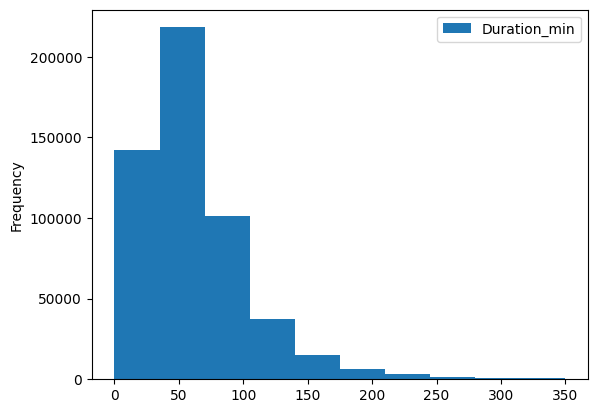

In [12]:
completed_orders[["Duration_min"]].plot.hist(bins=10, range=(0,350))
plt.show()

The duration is right skewed so we will use median to fill the missing data

In [13]:
import sys
sys.path.append("../scripts/")
from data_cleaning import CleanData
cleaner = CleanData()

In [14]:
completed_orders = cleaner.fill_missing(completed_orders,"median",["Duration_min"])
completed_orders.isna().sum()

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          0
Duration_min           0
dtype: int64

Fill the start time by subtracting duration from the end time

In [15]:
completed_orders = cleaner.fill_start_time(completed_orders,"Trip Start Time","Trip End Time","Duration_min")

completed_orders.isna().sum()

Trip ID             0
Trip Origin         0
Trip Destination    0
Trip Start Time     0
Trip End Time       0
Duration_min        0
dtype: int64

In [16]:
completed_orders.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Duration_min
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,1.550000
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,29.400000
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,41.350000
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,13.583333
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,3.616667


In [17]:
completed_orders=cleaner.remove_space(completed_orders)

Get the trip source

In [18]:
trip_origin=(completed_orders.groupby('trip_origin',as_index=False).agg(Count=('trip_id', 'count'))).sort_values(by="Count",ascending=False).reset_index(drop=True)
lat = trip_origin["trip_origin"].apply(lambda x:x.split(',')[0])
lon = trip_origin["trip_origin"].apply(lambda x:x.split(',')[1])
trip_origin['latitude'],trip_origin['longitude']=lat,lon
trip_origin.drop(columns="trip_origin",inplace=True)


In [19]:
trip_origin['longitude']=trip_origin['longitude'].astype('float')
trip_origin['latitude']=trip_origin['latitude'].astype('float')


In [20]:
trip_origin_head_50 = trip_origin.head(50)
trip_origin_head_50

,Count,latitude,longitude
0,888,6.613793,3.357997
1,668,6.462727,3.556790
2,576,6.429360,3.433497
3,544,6.428631,3.515512
4,543,6.443119,3.481437
5,538,6.622070,3.383825
6,538,6.444086,3.508050
7,522,6.595258,3.352143
8,520,6.452345,3.527539
9,514,6.437297,3.460993


In [23]:
trip_origin_head_50=cleaner.reverse_location(trip_origin_head_50)

GeocoderTimedOut: Service timed out

In [ ]:
trip_origin_head_50["location"]=trip_origin_head_50['location'].apply(lambda x:x.strip())
top_locations=trip_origin_head_50.groupby('location',as_index=False).agg({"Count":"sum"}).sort_values(by="Count",ascending=False)

/tmp/ipykernel_36107/2029669046.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



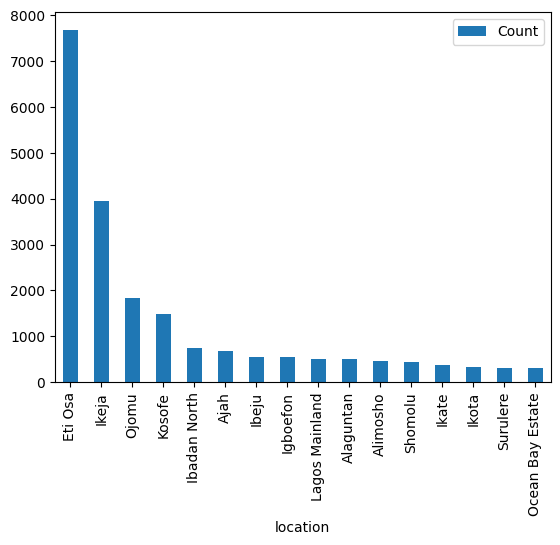

In [ ]:
top_locations.set_index("location",inplace=True)
top_locations.plot(kind='bar')
plt.show()

In [24]:
trip_destination=(completed_orders.groupby('trip_destination',as_index=False).agg(Count=('trip_id', 'count'))).sort_values(by="Count",ascending=False).reset_index(drop=True)
lat = trip_destination["trip_destination"].apply(lambda x:x.split(',')[0])
lon = trip_destination["trip_destination"].apply(lambda x:x.split(',')[1])
trip_destination['latitude'],trip_destination['longitude']=lat,lon
trip_destination.drop(columns="trip_destination",inplace=True)


In [25]:
trip_destination['longitude']=trip_destination['longitude'].astype('float')
trip_destination['latitude']=trip_destination['latitude'].astype('float')

In [26]:
trip_destination_head_50 = trip_destination.head(50)
trip_destination_head_50

,Count,latitude,longitude
0,844,6.456731,3.530940
1,794,6.448969,3.523179
2,735,6.497595,3.383098
3,732,6.583794,3.333552
4,727,6.452345,3.527539
5,565,6.455619,3.511717
6,556,6.442933,3.530137
7,547,6.445271,3.507169
8,486,6.423973,3.489252
9,485,6.447669,3.533437


In [27]:
trip_destination_head_50 = cleaner.reverse_location(trip_destination_head_50)

GeocoderTimedOut: Service timed out

In [ ]:
trip_destination_head_50["location"]=trip_destination_head_50['location'].apply(lambda x:x.strip())
top_locations=trip_destination_head_50.groupby('location',as_index=False).agg({"Count":"sum"}).sort_values(by="Count",ascending=False)

/tmp/ipykernel_36107/4129523109.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



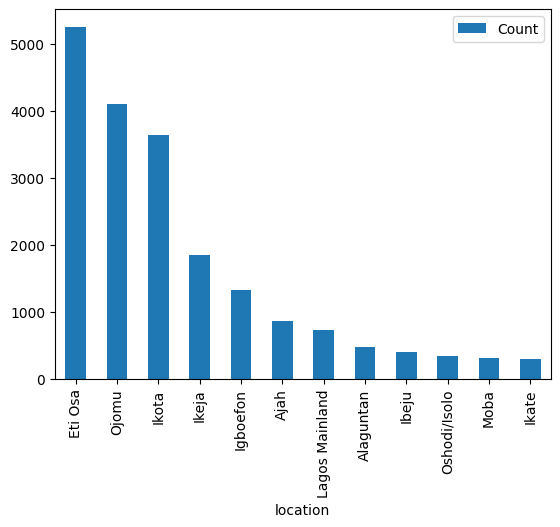

In [ ]:
top_locations.set_index("location",inplace=True)
top_locations.plot(kind='bar')
plt.show()

In [28]:
completed_orders = cleaner.find_distance(completed_orders)
completed_orders

,trip_id,trip_origin,trip_destination,trip_start_time,trip_end_time,duration_min,distance
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,1.550000,16.123451
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,29.400000,1.884305
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,41.350000,13.822393
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,13.583333,1.511034
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,3.616667,20.984319
...,...,...,...,...,...,...,...
536015,1637696,"6.448218499999999,3.4772075","6.437787399999999,3.481670199999999",2021-12-30 20:35:06,2021-12-30 21:02:59,27.883333,1.254752
536016,1637702,"6.442320899999999,3.4736868","6.436589333407897,3.5559738188407835",2021-12-30 20:48:13,2021-12-30 21:43:49,55.600000,9.124781
536017,1637704,"6.4281982,3.492248","6.448088500000001,3.4775747",2021-12-30 20:51:45,2021-12-30 21:41:32,49.783333,2.733704
536018,1637705,"6.5869296,3.3632966","6.637906899999999,3.3339515",2021-12-30 20:48:50,2021-12-30 21:08:28,19.633333,6.504796


In [29]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="gokada")
nigeria_holiday= holidays.Nigeria()

def check_holiday(order_time: datetime):
    return order_time.date() in nigeria_holiday

def add_holiday_feature(df: pd.DataFrame, date_col: str = "trip_start_time"):
    df["holiday"] = df[date_col].apply(lambda x: check_holiday(x))
    return df

In [30]:
completed_orders = add_holiday_feature(completed_orders)

In [31]:
labels= completed_orders["holiday"].value_counts().index
sizes= (completed_orders["holiday"].value_counts())

In [32]:
completed_orders

,trip_id,trip_origin,trip_destination,trip_start_time,trip_end_time,duration_min,distance,holiday
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,1.550000,16.123451,False
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,29.400000,1.884305,False
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,41.350000,13.822393,False
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,13.583333,1.511034,False
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,3.616667,20.984319,False
...,...,...,...,...,...,...,...,...
536015,1637696,"6.448218499999999,3.4772075","6.437787399999999,3.481670199999999",2021-12-30 20:35:06,2021-12-30 21:02:59,27.883333,1.254752,False
536016,1637702,"6.442320899999999,3.4736868","6.436589333407897,3.5559738188407835",2021-12-30 20:48:13,2021-12-30 21:43:49,55.600000,9.124781,False
536017,1637704,"6.4281982,3.492248","6.448088500000001,3.4775747",2021-12-30 20:51:45,2021-12-30 21:41:32,49.783333,2.733704,False
536018,1637705,"6.5869296,3.3632966","6.637906899999999,3.3339515",2021-12-30 20:48:50,2021-12-30 21:08:28,19.633333,6.504796,False


Visualize holiday

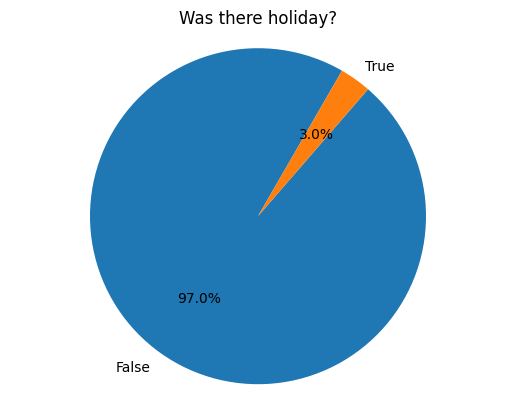

In [33]:
plt.pie(sizes,labels=labels,startangle=60, autopct='%1.1f%%')

plt.axis('equal')
plt.title("Was there holiday?")

plt.show()

In [34]:
completed_orders.to_csv("../data/completed_orders_cleaned.csv",index=False)

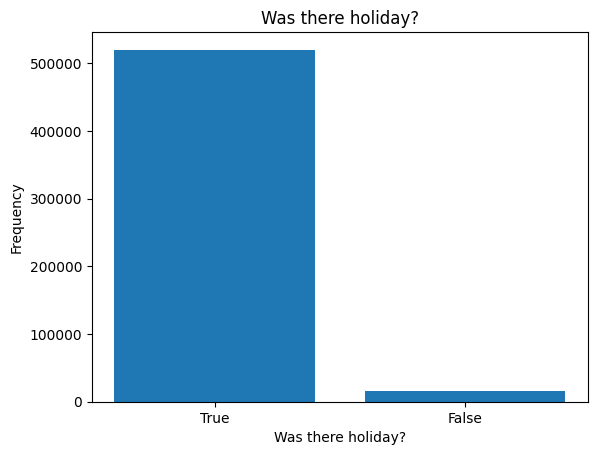

In [35]:
import matplotlib.pyplot as plt

# Retrieve the unique values and their counts
labels = ['True', 'False']
sizes = completed_orders["holiday"].value_counts()

# Plot bar plot
plt.bar(labels, sizes)

# Add labels and title
plt.xlabel("Was there holiday?")
plt.ylabel("Frequency")
plt.title("Was there holiday?")

plt.show()


save the file in csv

In [36]:
#completed_orders.to_csv("../data/completed_orders_cleaned.csv",index=False)